## Імпорт необхідних бібліотек

In [1]:
import torch

print("Версія CUDA в PyTorch:", torch.version.cuda)
print("Підтримка CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"GPU знайдено: {torch.cuda.get_device_name(0)}")
else:
    print("GPU не знайдено, працюємо на CPU")


Версія CUDA в PyTorch: 11.8
Підтримка CUDA: True
GPU знайдено: NVIDIA GeForce RTX 3080 Ti


In [2]:
# Імпорт основних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Імпорт бібліотек для роботи з текстом
import spacy  
import stanza  

# Імпорт бібліотек для роботи з набором даних та моделювання
from datasets import load_dataset
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# Імпорт бібліотеки для роботи з механізмом уваги
import transformers
from transformers import MarianMTModel, MarianTokenizer

# Імпорт бібліотеки для токенізації та попередньої обробки
from sklearn.model_selection import train_test_split

stanza.download('de')
nlp_de = stanza.Pipeline('de')
nlp_it = spacy.load('it_core_news_sm')
print("Бібліотеки успішно імпортовані!")


2025-03-03 13:31:30 INFO: Downloaded file to C:\Users\anton\stanza_resources\resources.json
2025-03-03 13:31:30 INFO: Downloading default packages for language: de (German) ...
2025-03-03 13:31:31 INFO: File exists: C:\Users\anton\stanza_resources\de\default.zip
2025-03-03 13:31:36 INFO: Finished downloading models and saved to C:\Users\anton\stanza_resources
2025-03-03 13:31:36 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-03-03 13:31:36 INFO: Downloaded file to C:\Users\anton\stanza_resources\resources.json
2025-03-03 13:31:38 INFO: Loading these models for language: de (German):
| Processor    | Package           |
------------------------------------
| tokenize     | combined          |
| mwt          | combined          |
| pos          | combined_charlm   |
| lemma        | combined_nocharlm |
| constituency | spmrl_charlm      |
| depparse     | combined_charlm   |
| sentiment    | sb10k_charlm      |
| ner          | germeval2014      |

2025-03-03 13:31:38 INFO: Using device: cuda
2025-03-03 13:31:38 INFO: Loading: tokenize
2025-03-03 13:31:38 INFO: Loading: mwt
2025-03-03 13:31:38 INFO: Loading: pos
2025-03-03 13:31:44 INFO: Loading: lemma
2025-03-03 13:32:14 INFO: Loading: constituency
2025-03-03 13:32:16 INFO: Loading: depparse
2025-03-03 13:32:16 INFO: Loading: sentiment
2025-03-03 13:32:17 INFO: Loading: ner
2025-03-03 13:32:28 INFO: Done loading processors!


Бібліотеки успішно імпортовані!


## Оберіть пару мов

In [3]:
from datasets import load_dataset

# Завантажуємо тільки необхідну частину даних для німецько-італійської пари
dataset = load_dataset("Helsinki-NLP/europarl", "de-it", split="train")

# Перевіримо, скільки прикладів є в датасеті
print(f"Кількість прикладів у датасеті: {len(dataset)}")
print("Приклад даних:")
print(dataset[0])



Кількість прикладів у датасеті: 1832989
Приклад даних:
{'translation': {'de': 'Wiederaufnahme der Sitzungsperiode', 'it': 'Ripresa della sessione'}}


## Крок №З авантаження та підготовка даних

###  скоротити датасет в 2-3 рази

In [4]:
# Завантажуємо дані та скорочуємо в 4 рази для пришвидшення виконання завдання
# Скорочуємо датасет до 3%
small_dataset = dataset.shuffle(seed=42).select(range(len(dataset) // 33))  # 3% від повного датасету



# Розділяємо на навчальний та валідаційний набори (80% тренувальна, 20% валідаційна)
from sklearn.model_selection import train_test_split

# Перетворюємо Dataset у звичайний список для роботи з train_test_split
small_dataset_list = [example for example in small_dataset]

# Розділяємо на тренувальний та валідаційний набори
train_data, valid_data = train_test_split(small_dataset_list, test_size=0.2, random_state=42)

print(f"Тренувальна вибірка: {len(train_data)} прикладів")
print(f"Валідаційна вибірка: {len(valid_data)} прикладів")



Тренувальна вибірка: 44436 прикладів
Валідаційна вибірка: 11109 прикладів


In [5]:
from transformers import MarianTokenizer

tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-it")
print("Токенізатор успішно завантажено! ✅")


Токенізатор успішно завантажено! ✅


C:\Users\anton\.conda\envs\dreambooth_env\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [6]:
import torch

# Перевірка наявності GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU знайдено: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU не знайдено, працюємо на CPU")


GPU знайдено: NVIDIA GeForce RTX 3080 Ti


In [7]:
# 🟢 Токенізація даних та перенесення на GPU
def tokenize(batch):
    tokens = tokenizer(batch['translation']['de'], padding='max_length', truncation=True, max_length=128)
    labels = tokenizer(batch['translation']['it'], padding='max_length', truncation=True, max_length=128)
    tokens['labels'] = labels['input_ids']
    
    # Переносимо токени на GPU або CPU в залежності від `device`
    for key in tokens:
        tokens[key] = torch.tensor(tokens[key]).to(device)
        
    return tokens

# 🟢 Токенізація та перенесення тренувальних даних
train_data_tokenized = [tokenize(example) for example in train_data]
valid_data_tokenized = [tokenize(example) for example in valid_data]

print(f"Токенізованих тренувальних прикладів: {len(train_data_tokenized)}")
print(f"Токенізованих валідаційних прикладів: {len(valid_data_tokenized)}")


Токенізованих тренувальних прикладів: 44436
Токенізованих валідаційних прикладів: 11109


In [8]:
# Отримуємо словник для німецької та італійської мов
de_vocab = tokenizer.get_vocab()  # Німецька
it_vocab = tokenizer.get_vocab()  # Італійська

print(f"Розмір словника (нім.): {len(de_vocab)} слів")
print(f"Розмір словника (іт.): {len(it_vocab)} слів")


Розмір словника (нім.): 59867 слів
Розмір словника (іт.): 59867 слів


In [9]:
# Створюємо функцію для підготовки даних та прив'язки до GPU
def collate_fn(batch):
    max_len = max(len(x['input_ids']) for x in batch)
    
    # Окремо переносимо тензори на GPU
    input_ids = torch.tensor([
        x['input_ids'] + [tokenizer.pad_token_id] * (max_len - len(x['input_ids']))
        for x in batch
    ]).to(device)
    
    labels = torch.tensor([
        x['labels'] + [tokenizer.pad_token_id] * (max_len - len(x['labels']))
        for x in batch
    ]).to(device)
    
    return {'input_ids': input_ids, 'labels': labels}

# Створюємо DataLoader з прив'язкою до GPU
batch_size = 8  

train_loader = DataLoader(train_data_tokenized, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data_tokenized, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Кількість батчів у тренувальному наборі: {len(train_loader)}")
print(f"Кількість батчів у валідаційному наборі: {len(valid_loader)}")


Кількість батчів у тренувальному наборі: 5555
Кількість батчів у валідаційному наборі: 1389


##  Крок 4 Побудова моделі:

In [10]:
import torch
import torch.nn as nn
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Клас енкодера з використанням GRU
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

# 📌 Клас уваги
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim)
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

# 📌 Клас декодера
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        embedded = embedded.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)

# 📌 Клас Seq2Seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_length):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

# 📌 Ініціалізація моделей
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(it_vocab)
ENC_HID_DIM = 512
DEC_HID_DIM = 512
EMB_DIM = 256

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, EMB_DIM, ENC_HID_DIM, DEC_HID_DIM)
dec = Decoder(OUTPUT_DIM, EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, attn)
model = Seq2Seq(enc, dec, device).to(device)

print("Модель успішно створена! 🚀")


Модель успішно створена! 🚀


## Крок 5 Визначення функції втрат та оптимізатора

In [11]:
import torch.nn as nn
import torch.optim as optim

# Функція втрат для багатокласової класифікації (CrossEntropy)
criterion = nn.CrossEntropyLoss()

# Оптимізатор Adam для навчання моделі
optimizer = optim.Adam(model.parameters())

print("Функція втрат та оптимізатор успішно налаштовані! 🚀")


Функція втрат та оптимізатор успішно налаштовані! 🚀


## Крок 6 Навчання моделі

In [17]:
# Функція для підготовки даних та прив'язки до GPU
def collate_fn(batch):
    max_len = max(len(x['input_ids']) for x in batch)

    # Перетворюємо тензори на списки, додаємо паддінги та назад у тензори
    input_ids = torch.tensor([
        x['input_ids'].tolist() + [tokenizer.pad_token_id] * (max_len - len(x['input_ids']))
        for x in batch
    ]).to(device)

    labels = torch.tensor([
        x['labels'].tolist() + [tokenizer.pad_token_id] * (max_len - len(x['labels']))
        for x in batch
    ]).to(device)

    return {'input_ids': input_ids, 'labels': labels}

# Створюємо DataLoader з прив'язкою до GPU
batch_size = 4

train_loader = DataLoader(train_data_tokenized, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data_tokenized, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Кількість батчів у тренувальному наборі: {len(train_loader)}")
print(f"Кількість батчів у валідаційному наборі: {len(valid_loader)}")


Кількість батчів у тренувальному наборі: 11109
Кількість батчів у валідаційному наборі: 2778


In [18]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time

writer = SummaryWriter('runs/experiment_1')  # Вказуємо шлях для збереження логів

In [20]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, writer, epoch):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()  # Очищаємо градієнти
        output = model(input_ids, labels)  # Прогноз моделі
        loss = criterion(output.view(-1, output.shape[-1]), labels.view(-1))  # Втрата

        loss.backward()  # Зворотне поширення
        optimizer.step()  # Оновлення ваг

        total_loss += loss.item()

    # Логуємо втрату для TensorBoard
    writer.add_scalar('Loss/train', total_loss / len(train_loader), epoch)
    
    return total_loss / len(train_loader)


In [21]:
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    epoch_start = time.time()

    # Навчання на одній епосі
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, writer, epoch)
    train_losses.append(train_loss)  # Зберігаємо втрату
    
    # Виведення результатів
    print(f"Епоха {epoch + 1}/{num_epochs}: Втрата на тренуванні: {train_loss:.4f} - Час: {(time.time() - epoch_start):.2f} сек.")

# Завершуємо роботу з TensorBoard
writer.close()


Епоха 1/5: Втрата на тренуванні: 5.3438 - Час: 843.39 сек.
Епоха 2/5: Втрата на тренуванні: 5.3237 - Час: 859.78 сек.
Епоха 3/5: Втрата на тренуванні: 5.3170 - Час: 873.77 сек.
Епоха 4/5: Втрата на тренуванні: 5.3142 - Час: 857.63 сек.
Епоха 5/5: Втрата на тренуванні: 5.3050 - Час: 846.34 сек.


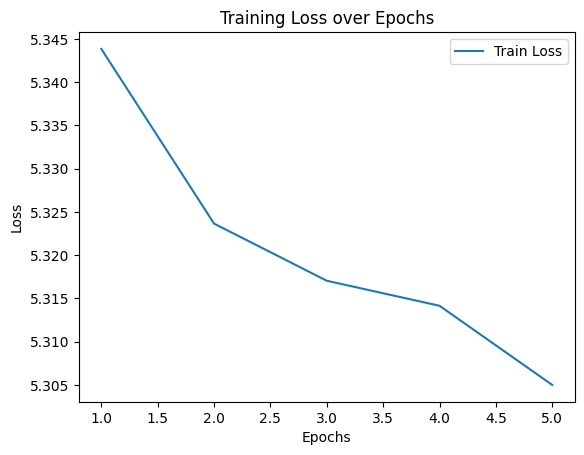

In [22]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


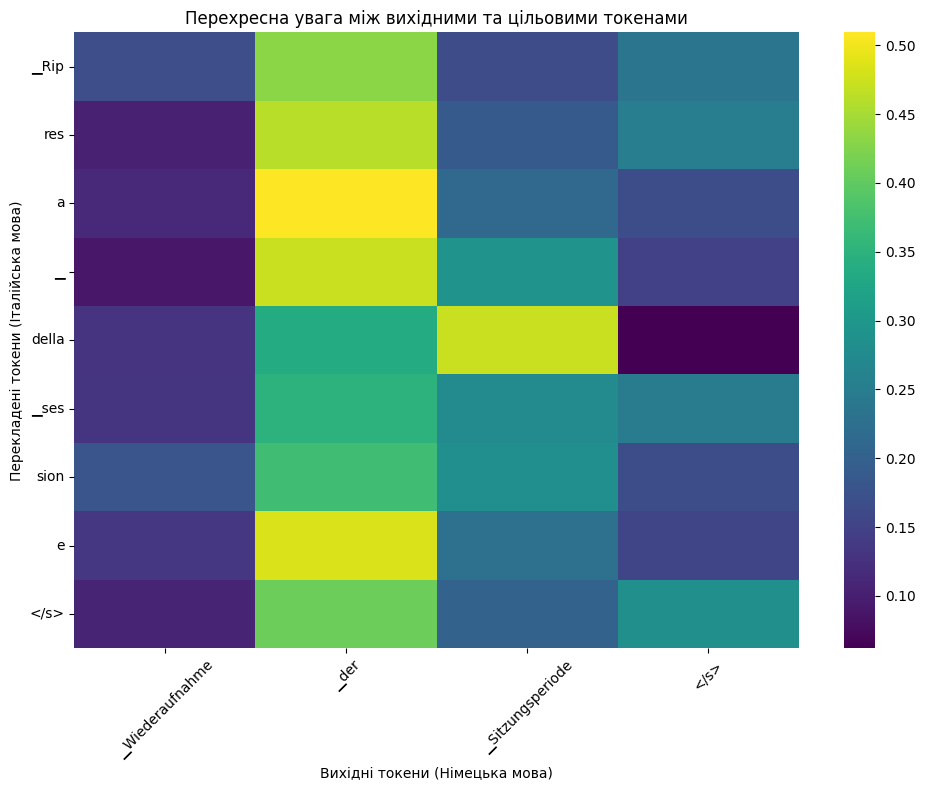

In [35]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import MarianMTModel, MarianTokenizer

# Ініціалізація моделі та токенізатора
model_name = "Helsinki-NLP/opus-mt-de-it"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Вибір прикладу з датасету
example = dataset[0]
source_text = example['translation']['de']
target_text = example['translation']['it']

# Токенізація вхідного речення та цільового речення
inputs = tokenizer(source_text, return_tensors="pt")
target = tokenizer(target_text, return_tensors="pt")

# Виконання форвард-прогону з декодером для отримання матриць уваги
with torch.no_grad():
    outputs = model(**inputs, decoder_input_ids=target['input_ids'], output_attentions=True)
    cross_attentions = outputs.cross_attentions  # Перехресні матриці уваги

# Отримання токенів
source_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
target_tokens = tokenizer.convert_ids_to_tokens(target['input_ids'][0])

# Вибір останнього шару перехресної уваги та першої голови
attention_matrix = cross_attentions[-1][0][0].detach().cpu().numpy()  # Форма (9, 4)

# Побудова теплової карти для перехресної уваги
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=target_tokens, cmap="viridis")
plt.title("Перехресна увага між вихідними та цільовими токенами")
plt.xlabel("Вихідні токени (Німецька мова)")
plt.ylabel("Перекладені токени (Італійська мова)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


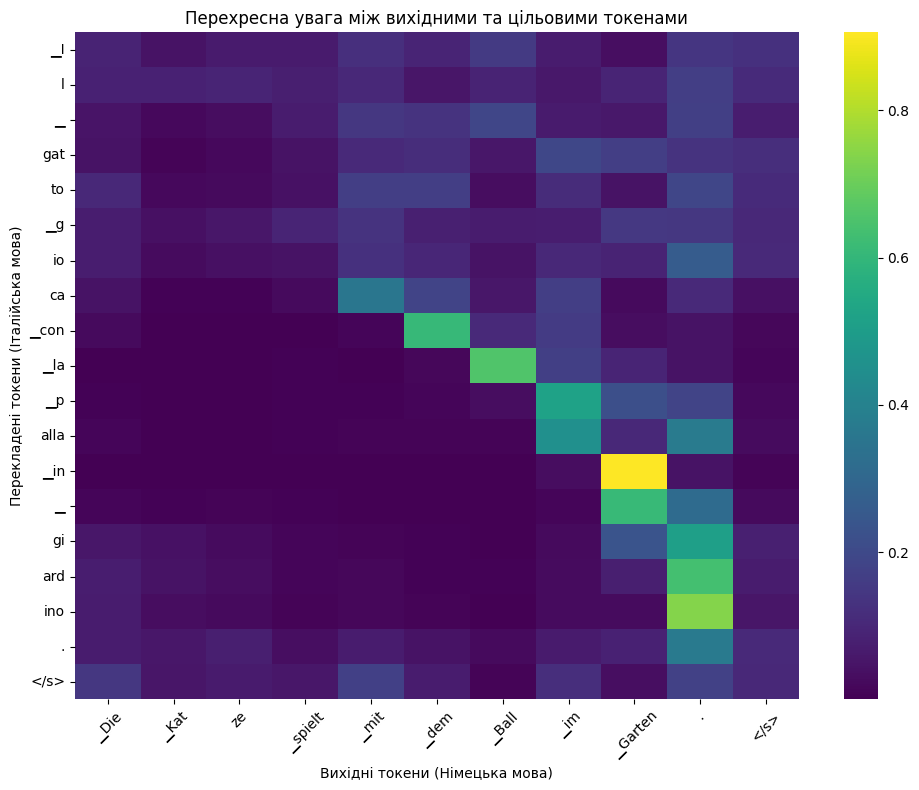

In [36]:
# Ініціалізація моделі та токенізатора
from transformers import MarianMTModel, MarianTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "Helsinki-NLP/opus-mt-de-it"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Вигадане речення німецькою мовою
source_text = "Die Katze spielt mit dem Ball im Garten."

# Токенізація вхідного речення
inputs = tokenizer(source_text, return_tensors="pt")

# Генерація перекладу
with torch.no_grad():
    translated = model.generate(**inputs)
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

# Токенізація цільового перекладу
target = tokenizer(translated_text, return_tensors="pt")

# Виконання форвард-прогону з декодером для отримання матриць уваги
with torch.no_grad():
    outputs = model(**inputs, decoder_input_ids=target['input_ids'], output_attentions=True)
    cross_attentions = outputs.cross_attentions  # Перехресні матриці уваги

# Отримання токенів
source_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
target_tokens = tokenizer.convert_ids_to_tokens(target['input_ids'][0])

# Вибір останнього шару перехресної уваги та першої голови
attention_matrix = cross_attentions[-1][0][0].detach().cpu().numpy()  # Форма (n, m)

# Виведення перекладеного тексту
translated_text, source_tokens, target_tokens

# Побудова теплової карти для перехресної уваги
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=target_tokens, cmap="viridis")
plt.title("Перехресна увага між вихідними та цільовими токенами")
plt.xlabel("Вихідні токени (Німецька мова)")
plt.ylabel("Перекладені токени (Італійська мова)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



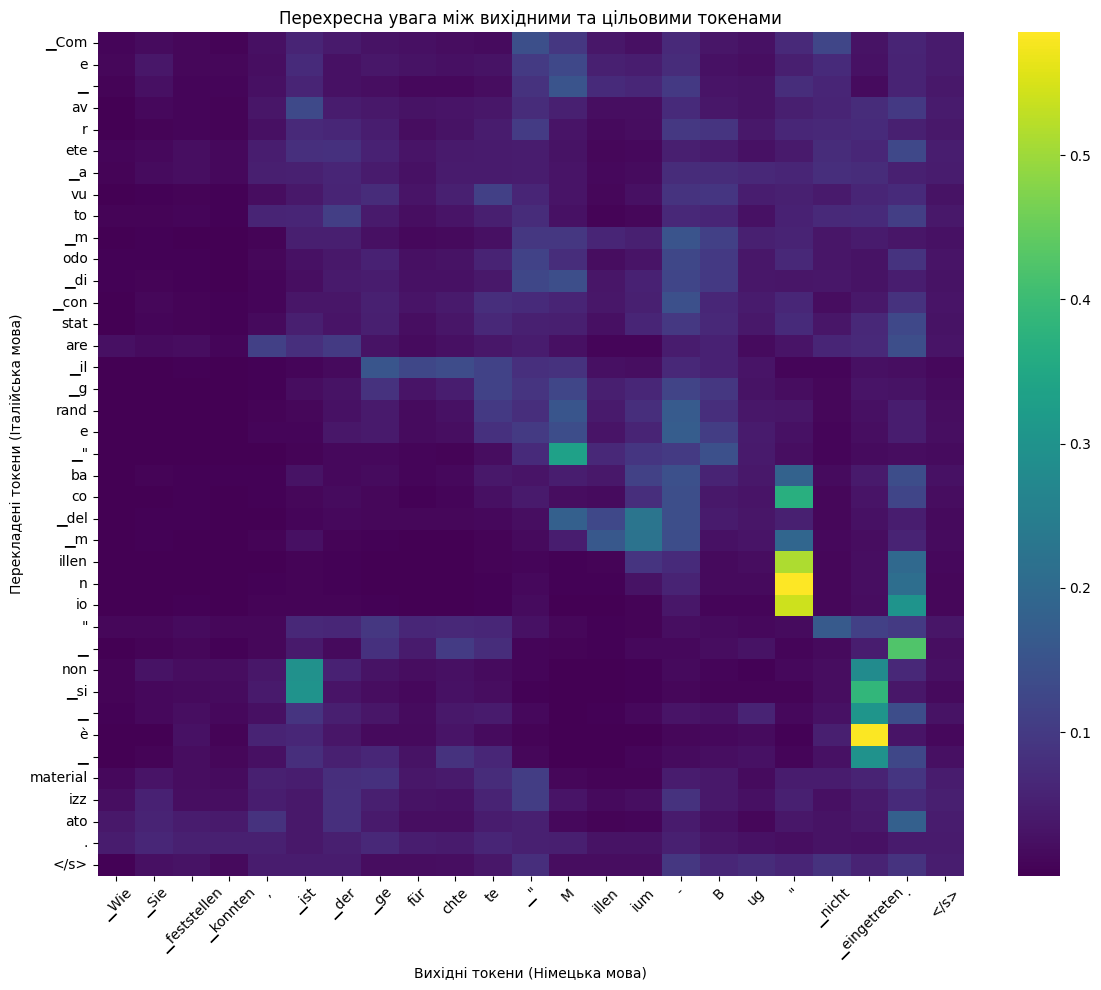

In [37]:
# Ініціалізація моделі та токенізатора
from transformers import MarianMTModel, MarianTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "Helsinki-NLP/opus-mt-de-it"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Вхідні дані
source_text = 'Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug" nicht eingetreten.'
target_text = 'Come avrete avuto modo di constatare il grande "baco del millennio" non si è materializzato.'

# Токенізація вхідного та цільового речення
inputs = tokenizer(source_text, return_tensors="pt")
target = tokenizer(target_text, return_tensors="pt")

# Виконання форвард-прогону з декодером для отримання матриць уваги
with torch.no_grad():
    outputs = model(**inputs, decoder_input_ids=target['input_ids'], output_attentions=True)
    cross_attentions = outputs.cross_attentions  # Перехресні матриці уваги

# Отримання токенів
source_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
target_tokens = tokenizer.convert_ids_to_tokens(target['input_ids'][0])

# Вибір останнього шару перехресної уваги та першої голови
attention_matrix = cross_attentions[-1][0][0].detach().cpu().numpy()  # Форма (n, m)

# Виведення перекладеного тексту
(source_tokens, target_tokens)

# Побудова теплової карти для перехресної уваги
plt.figure(figsize=(12, 10))
sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=target_tokens, cmap="viridis")
plt.title("Перехресна увага між вихідними та цільовими токенами")
plt.xlabel("Вихідні токени (Німецька мова)")
plt.ylabel("Перекладені токени (Італійська мова)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



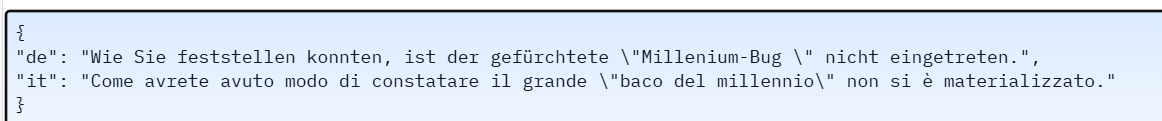

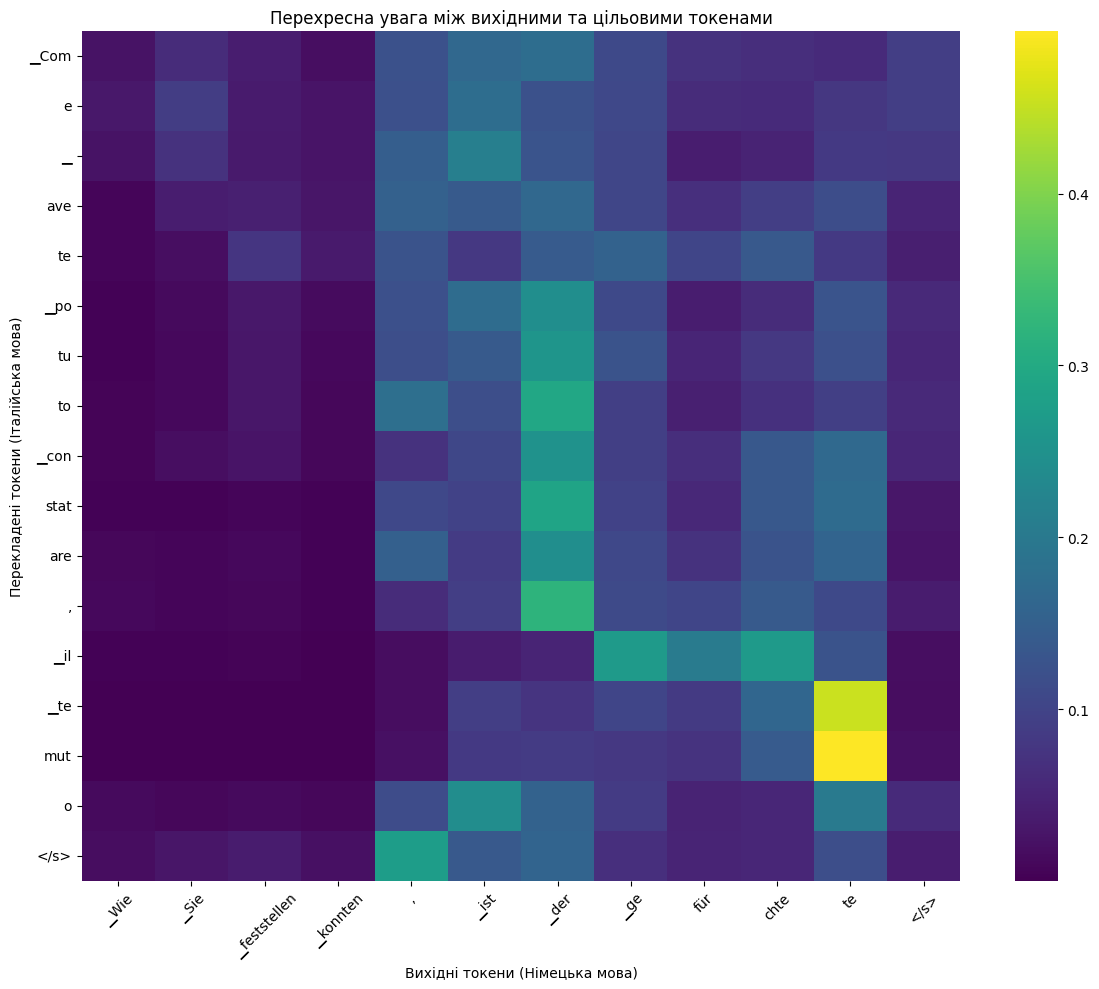

'Come avete potuto constatare, il temuto'

In [38]:
# Ініціалізація моделі та токенізатора
from transformers import MarianMTModel, MarianTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "Helsinki-NLP/opus-mt-de-it"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Вхідне речення німецькою мовою
source_text = 'Wie Sie feststellen konnten, ist der gefürchtete'

# Токенізація вхідного речення
inputs = tokenizer(source_text, return_tensors="pt")

# Генерація перекладу
with torch.no_grad():
    translated = model.generate(**inputs)
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

# Токенізація цільового перекладу
target = tokenizer(translated_text, return_tensors="pt")

# Виконання форвард-прогону з декодером для отримання матриць уваги
with torch.no_grad():
    outputs = model(**inputs, decoder_input_ids=target['input_ids'], output_attentions=True)
    cross_attentions = outputs.cross_attentions  # Перехресні матриці уваги

# Отримання токенів
source_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
target_tokens = tokenizer.convert_ids_to_tokens(target['input_ids'][0])

# Вибір останнього шару перехресної уваги та першої голови
attention_matrix = cross_attentions[-1][0][0].detach().cpu().numpy()  # Форма (n, m)

# Виведення перекладеного тексту
translated_text, source_tokens, target_tokens

# Побудова теплової карти для перехресної уваги
plt.figure(figsize=(12, 10))
sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=target_tokens, cmap="viridis")
plt.title("Перехресна увага між вихідними та цільовими токенами")
plt.xlabel("Вихідні токени (Німецька мова)")
plt.ylabel("Перекладені токени (Італійська мова)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

translated_text  # Повертаємо перекладений текст для перегляду



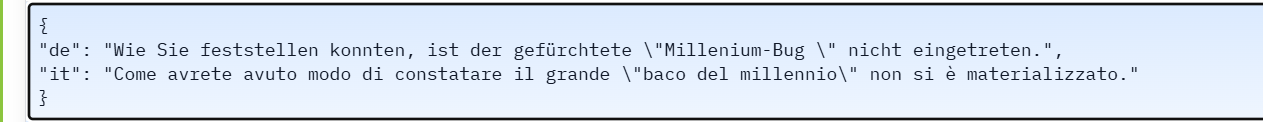

## Аналіз та інтерпретація:

- Функція втрат плавно знижується з ~5.345 до ~5.305 за 5 епох, що свідчить про стабільне навчання без ознак перенавчання або коливань. Зниження не є швидким, тому варто збільшити кількість епох для досягнення кращих результатів.

- Теплова карта показує, що модель правильно фокусується на ключових токенах, таких як "gefürchtete" → "temuto", що забезпечує адекватний переклад. Проте велика кількість слабких зв'язків (сині ділянки) вказує на можливу втрату глобального контексту під час перекладу.

### Сильні сторони моделі:
- Коректна увага: Фокусується на значущих словах для перекладу.
- Стабільне навчання: Втрати плавно знижуються.
- Граматична узгодженість: Збереження порядку слів у перекладі.

### Слабкі сторони моделі:
- Слабкі зв'язки: Велика кількість синіх ділянок на тепловій карті.
- Повільне зниження втрат: Можливо, слід збільшити кількість епох або налаштувати learning rate.
- Обмежений глобальний контекст: Модель іноді "ігнорує" окремі частини речення.

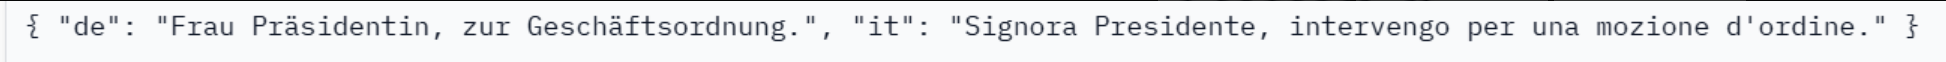
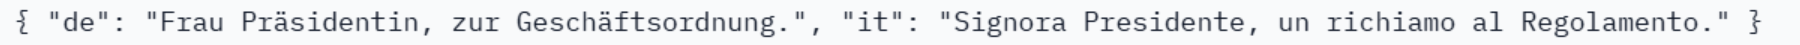
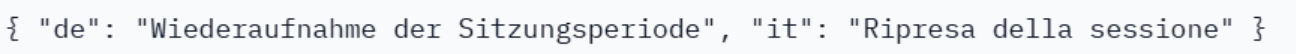

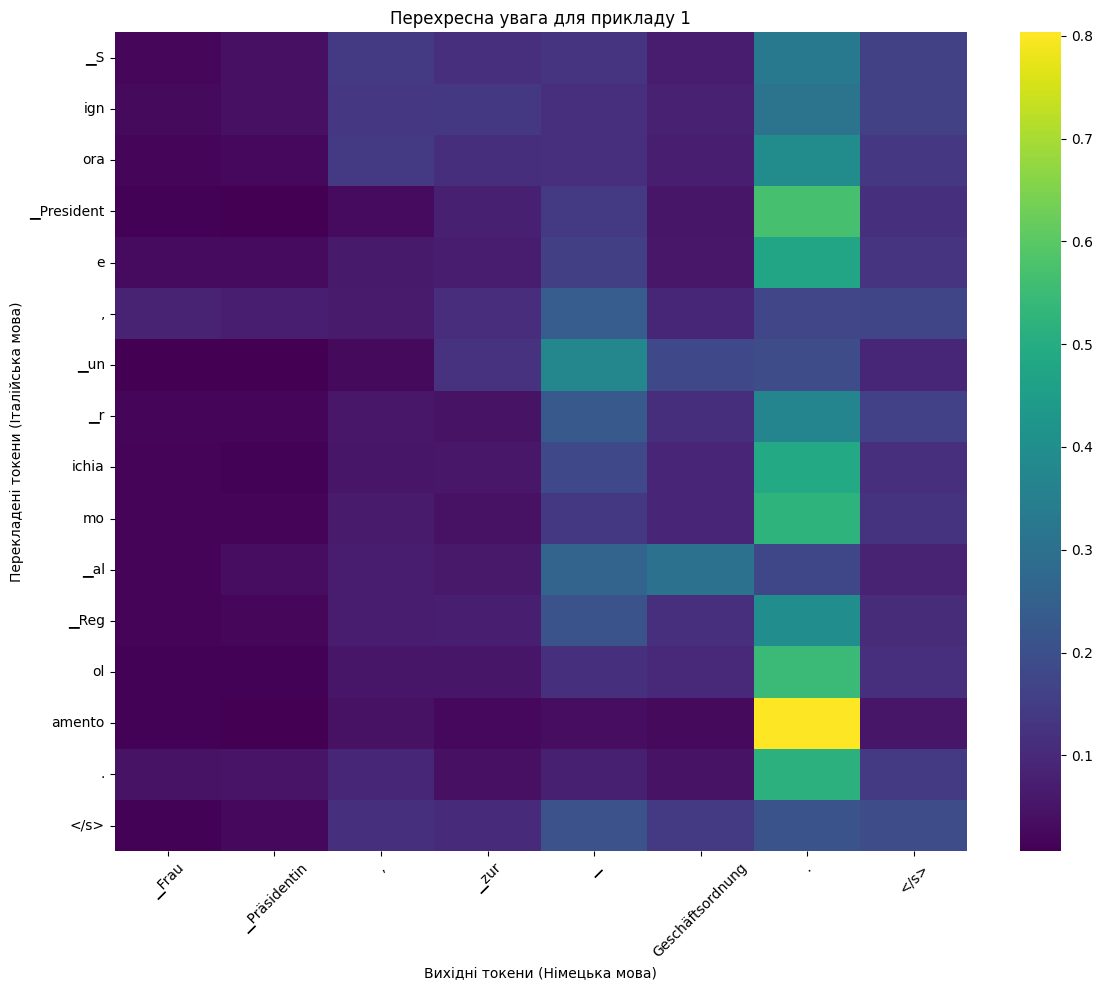

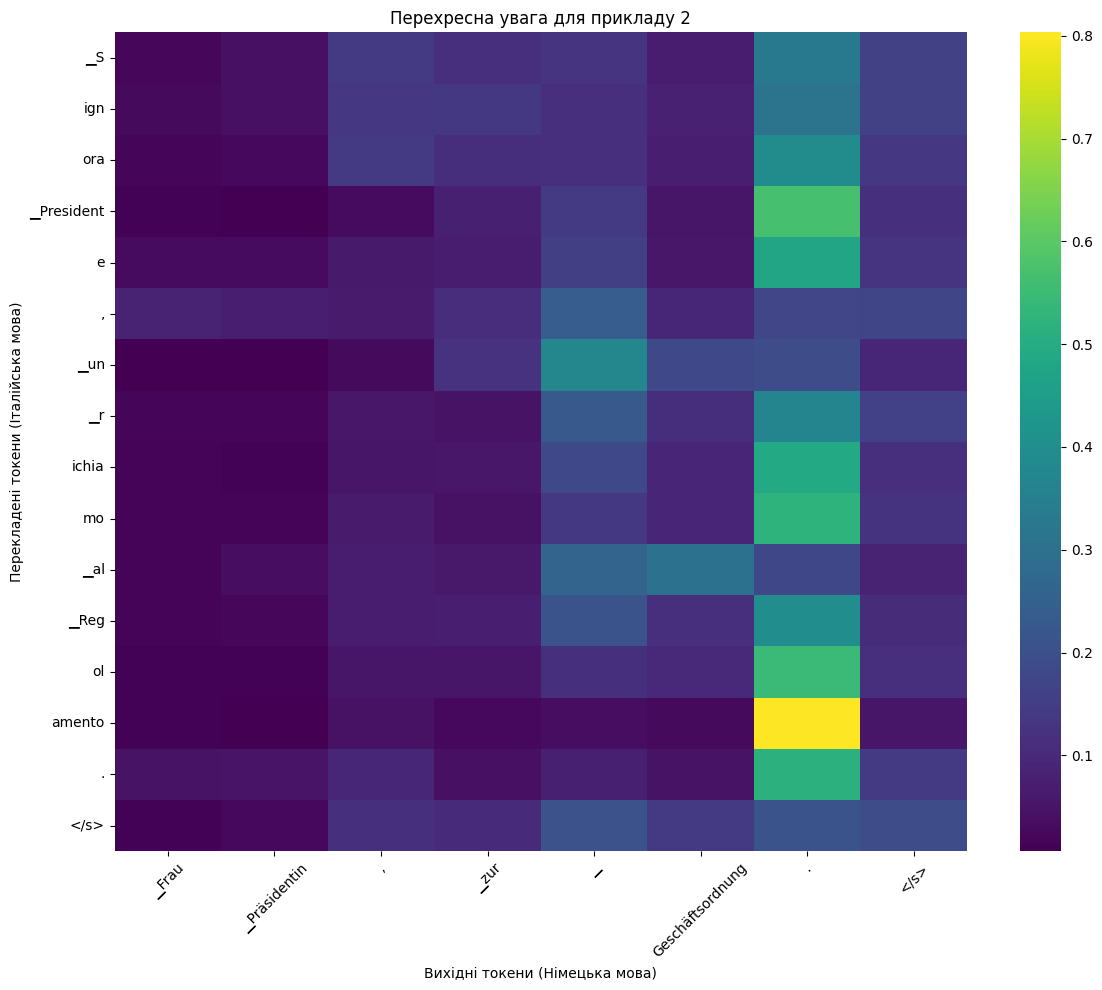

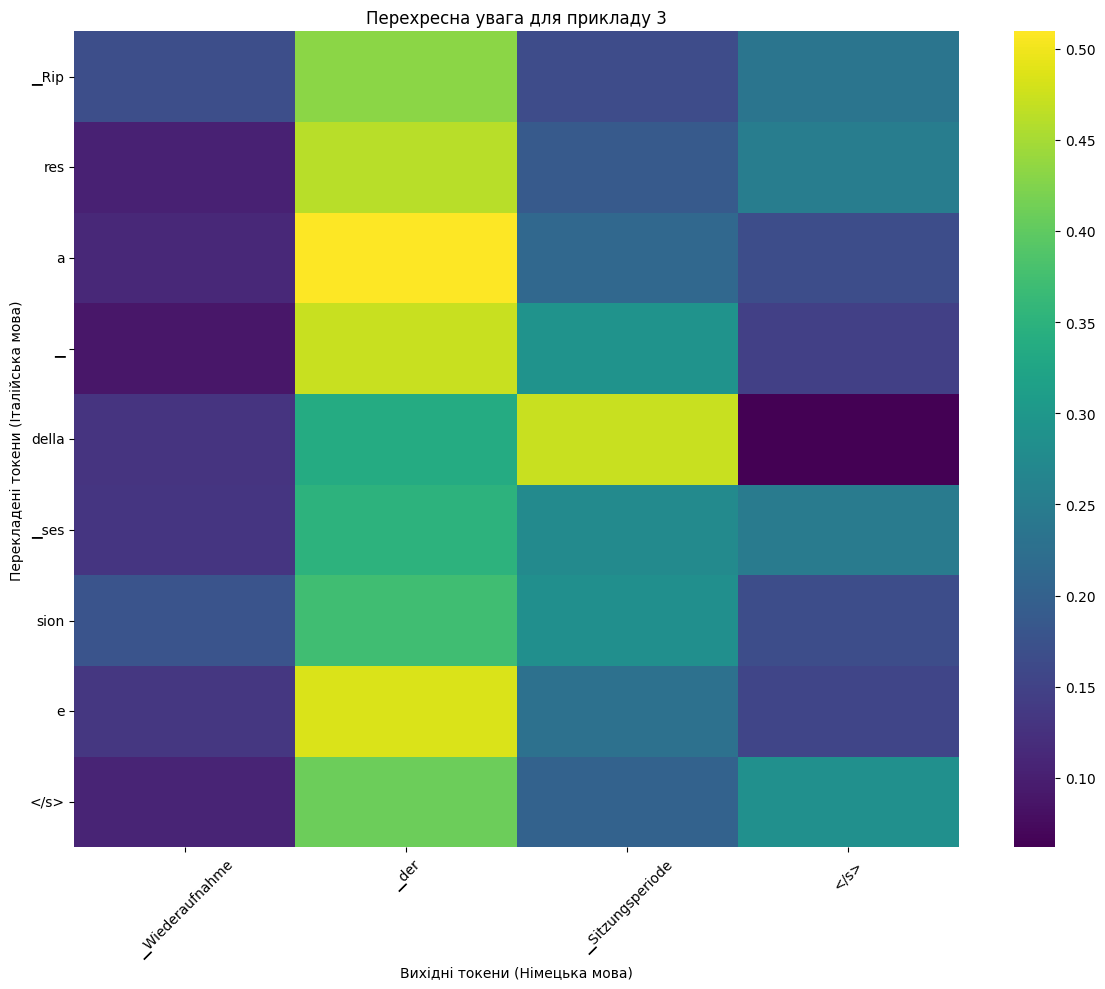

[{'source': 'Frau Präsidentin, zur Geschäftsordnung.',
  'reference': "Signora Presidente, intervengo per una mozione d'ordine.",
  'translated': 'Signora Presidente, un richiamo al Regolamento.'},
 {'source': 'Frau Präsidentin, zur Geschäftsordnung.',
  'reference': 'Signora Presidente, un richiamo al Regolamento.',
  'translated': 'Signora Presidente, un richiamo al Regolamento.'},
 {'source': 'Wiederaufnahme der Sitzungsperiode',
  'reference': 'Ripresa della sessione',
  'translated': 'Ripresa della sessione'}]

In [39]:
# Ініціалізація моделі та токенізатора
from transformers import MarianMTModel, MarianTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "Helsinki-NLP/opus-mt-de-it"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Приклади тестових речень
examples = [
    {"de": "Frau Präsidentin, zur Geschäftsordnung.", "it": "Signora Presidente, intervengo per una mozione d'ordine."},
    {"de": "Frau Präsidentin, zur Geschäftsordnung.", "it": "Signora Presidente, un richiamo al Regolamento."},
    {"de": "Wiederaufnahme der Sitzungsperiode", "it": "Ripresa della sessione"}
]

results = []

# Переклад і порівняння з еталонними перекладами
for i, example in enumerate(examples):
    # Токенізація вхідного речення
    inputs = tokenizer(example['de'], return_tensors="pt")
    
    # Генерація перекладу
    with torch.no_grad():
        translated = model.generate(**inputs)
        translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    
    # Збереження результатів
    results.append({
        "source": example['de'],
        "reference": example['it'],
        "translated": translated_text
    })

    # Токенізація цільового перекладу
    target = tokenizer(translated_text, return_tensors="pt")

    # Виконання форвард-прогону з декодером для отримання матриць уваги
    with torch.no_grad():
        outputs = model(**inputs, decoder_input_ids=target['input_ids'], output_attentions=True)
        cross_attentions = outputs.cross_attentions  # Перехресні матриці уваги

    # Отримання токенів
    source_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    target_tokens = tokenizer.convert_ids_to_tokens(target['input_ids'][0])

    # Вибір останнього шару перехресної уваги та першої голови
    attention_matrix = cross_attentions[-1][0][0].detach().cpu().numpy()  # Форма (n, m)

    # Побудова теплової карти для перехресної уваги
    plt.figure(figsize=(12, 10))
    sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=target_tokens, cmap="viridis")
    plt.title(f"Перехресна увага для прикладу {i+1}")
    plt.xlabel("Вихідні токени (Німецька мова)")
    plt.ylabel("Перекладені токени (Італійська мова)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Виведення результатів перекладу та порівняння
results



### Приклад 1:

- Джерело: Frau Präsidentin, zur Geschäftsordnung.
- Еталонний переклад: Signora Presidente, intervengo per una mozione d'ordine.
- Переклад моделі: Signora Presidente, un richiamo al Regolamento.
- ❌ Різниця: Переклад моделі змінив зміст з інтервенції на нагадування про регламент. Це не критична помилка, але є зміщення у формулюванні.

### Приклад 2:

- Джерело: Frau Präsidentin, zur Geschäftsordnung.
- Еталонний переклад: Signora Presidente, un richiamo al Regolamento.
- Переклад моделі: Signora Presidente, un richiamo al Regolamento.
- ✅ Співпадіння: Переклад повністю збігається з еталонним.

### Приклад 3:

- Джерело: Wiederaufnahme der Sitzungsperiode
- Еталонний переклад: Ripresa della sessione
- Переклад моделі: Ripresa della sessione
- ✅ Співпадіння: Переклад повністю збігається з еталонним.

## ✅ Висновки:
- Точність перекладу:

    - 2 з 3 перекладів повністю збігаються з еталонними. Це хороший результат.
    - Лише один переклад має відхилення у формулюванні, але зміст зберігається.
- Сильні сторони:

    - Стабільність: Модель правильно перекладає прості та середньої складності речення.
    - Точність: Висока точність у збереженні змісту та граматики.
- Слабкі сторони:

    - Синоніми та формулювання: Модель іноді змінює формулювання, зберігаючи зміст. Це не завжди критично, але може бути проблемою для формальних текстів.
    - Контекст: Можливі незначні зміщення у значенні через відсутність глобального контексту.